# Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Combine target and features into one dataframe

In [2]:
# Monthly series
df1 = pd.read_csv("files/Monthly stationary series.csv")
# Extracted features
df2 = pd.read_csv("files/Monthly Extracted Features.csv")
df2.columns.array[0] = 'DATE 2 Features'
# Combine
features = pd.concat([df1, df2], axis=1)
features = features.drop('DATE 2 Features', axis=1) # Drop 'DATE' column for redundancy
features = features.drop(0)                       # Drop first row
features = features.drop(features.index[-1])      # Drop last row
features = features.reset_index(drop=True)

# Target
target = pd.read_csv("files/Target.csv")
complete_set = pd.concat([target, features], axis=1)
complete_set.columns.array[3]= "DATE Features"
print(complete_set.iloc[:, 0:5])


'''
There are two columns with dates, as one functions for the target (see column 0: DATE) at time t+1, and the other (see column 4: DATE Features) for the feature date at time t.
'''

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990          0.100
1    01/04/1990         0.98        0.02    01/03/1990          0.000
2    01/05/1990         0.30        0.70    01/04/1990         -0.600
3    01/06/1990         0.00        1.00    01/05/1990         -0.400
4    01/07/1990         0.00        1.00    01/06/1990          0.400
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021          0.003
378  01/09/2021         0.00        1.00    01/08/2021         -0.253
379  01/10/2021         0.65        0.35    01/09/2021          0.381
380  01/11/2021         0.00        1.00    01/10/2021          2.171
381  01/12/2021         0.67        0.33    01/11/2021          1.518

[382 rows x 5 columns]


# Standardize features

In [3]:
df = complete_set

# Separate the years, target columns, and features
years = df.iloc[:, 3]
target_columns = df.iloc[:, 1:3]
features = df.iloc[:, 4:]

# Identify the indices corresponding to the training and test periods
train_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '1990-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2010-12-31')
valid_and_test_indices = (pd.to_datetime(years, format='%d/%m/%Y') >= '2011-01-01') & (pd.to_datetime(years, format='%d/%m/%Y') <= '2021-12-31')

# Extract the training and test features
X_train = features[train_indices]
X_valid_and_test = features[valid_and_test_indices]

# Calculate mean and standard deviation using only the training data
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Standardize the training and test features using the training statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_and_test_scaled = scaler.transform(X_valid_and_test)

# Replace the original feature columns with the standardized ones
df.iloc[train_indices, 4:] = X_train_scaled
df.iloc[valid_and_test_indices, 4:] = X_valid_and_test_scaled
print(df.iloc[:, :5])
df.to_csv("files/Standardized features.csv")

           DATE  Stock index  Bond Index DATE Features  CPIAUCNS yoy 
0    01/03/1990         0.70        0.30    01/02/1990       0.138627
1    01/04/1990         0.98        0.02    01/03/1990       0.015108
2    01/05/1990         0.30        0.70    01/04/1990      -0.726010
3    01/06/1990         0.00        1.00    01/05/1990      -0.478971
4    01/07/1990         0.00        1.00    01/06/1990       0.509186
..          ...          ...         ...           ...            ...
377  01/08/2021         0.99        0.01    01/07/2021       0.018813
378  01/09/2021         0.00        1.00    01/08/2021      -0.297397
379  01/10/2021         0.65        0.35    01/09/2021       0.485718
380  01/11/2021         0.00        1.00    01/10/2021       2.696720
381  01/12/2021         0.67        0.33    01/11/2021       1.890136

[382 rows x 5 columns]


# MLP: tune hyper-parameters for one window

- Each layer can have a unique number of neurons. 
- The dropout rate is the same in each hidden layer
- Batch normalization occurs after each hidden layer or does not occur at all


In [4]:
# Set the seed for reproducibility purposes
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def optimize_hyperparameters(X_train, y_train, X_val, y_val):
    def build_model(hp):
        model = Sequential()
        
        # Input layer & first hidden layer
        model.add(Dense(units=hp.Choice('N_neurons_layer_1', values=[8, 16, 32, 64, 128]), input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(hp.Choice('Dropout_rate', values=[0.0, 0.25, 0.5])))
        if hp.Choice('Batch_normalization', values=[True, False]):
            model.add(BatchNormalization())

        # Minimum of 2 and maximum of 3 hidden layers
        n_hidden_layers = hp.Choice('N_hidden_layers', values=[2, 3])
        
        # Layer 2
        if n_hidden_layers == 2:
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())    
        else:
            # Layer 2
            model.add(Dense(units=hp.Choice('N_neurons_layer_2', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())
                                    
            # Layer 3
            model.add(Dense(units=hp.Choice('N_neurons_layer_3', values=[8, 16, 32, 64, 128]), activation='relu'))
            model.add(Dropout(hp.Choice('Dropout_rate',  values=[0.0, 0.25, 0.5])))
            if hp.Choice('Batch_normalization', values=[True, False]):
                model.add(BatchNormalization())

                
        # Output: weight_stock_index & weight_bond_index
        model.add(Dense(units=2, activation='softmax'))

        # Learning rates for Adam (default=0.001)
        lr = hp.Choice('Learning_rate', values=[0.01, 0.0001, 0.001])
        optimizer = keras.optimizers.Adam(learning_rate=lr)
   
        # Compile model
        model.compile(optimizer=optimizer, loss='mean_absolute_errSor', metrics=['mean_absolute_error'])
        return model
    
    tuner = kt.RandomSearch(
        build_model,
        objective=kt.Objective('val_mean_absolute_error', direction='min'),
        max_trials=100,
        seed=42,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite= True)
        
    tuner.search(x=X_train,
                 y=y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(X_val, y_val))
    
    # Get the best hyperparameters and the best trial
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters = best_trial.hyperparameters

    return best_hyperparameters.values

# MLP: call function for each window to extract tuned hyper-parameters

In [5]:
# Pre-define table for hyper-parameter results
hp_results = pd.DataFrame(
    {"Window":              [None, None, None, None, None, None],
     "N_hidden_layers":     [None, None, None, None, None, None],
     "N_neurons_layer_1":   [None, None, None, None, None, None],
     "N_neurons_layer_2":   [None, None, None, None, None, None],
     "N_neurons_layer_3":   [None, None, None, None, None, None],
     "Batch_normalization": [None, None, None, None, None, None],
     "Dropout_rate":        [None, None, None, None, None, None],
     "Learning_rate":       [None, None, None, None, None, None],
     "MAE":                 [None, None, None, None, None, None]
    })

# Date (column 1), target (column B & C), Sharpe ratio (Column D), & features (column E & onwards)
exclude_bottom = ['1990', '1991', '1992', '1993', '1994']
exclude_top = ['2016', '2017', '2018', '2019', '2020', '2021']
validation_years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

start_year_validation = 0
end_year_validation = 5
for window in range(6):
    # Getting training data
    exclude_1 = exclude_bottom[:window]
    exclude_2 = exclude_top[window:]
    exclude_concat = exclude_1 + exclude_2
    full_window = df[~df['DATE'].str.contains('|'.join(exclude_concat))]

    # Training + validation set
    val_years = validation_years[start_year_validation:end_year_validation]
    train_set = full_window[~full_window['DATE'].str.contains('|'.join(val_years))]
    X_train = train_set.iloc[:, 4:]
    y_train = train_set.iloc[:, [1, 2]]
    
    # Validation set
    val_set = full_window[full_window['DATE'].str.contains('|'.join(val_years))]
    X_val = val_set.iloc[:, 4:]
    y_val = val_set.iloc[:, [1, 2]]

    start_year_validation += 1
    end_year_validation += 1

    results_one_window = optimize_hyperparameters(X_train, y_train, X_val, y_val)
    
    #Allocate results to dataframe
    hp_results.at[window, "Window"] = window
    hp_results.at[window, "N_hidden_layers"] = results_one_window['N_hidden_layers']
    hp_results.at[window, "N_neurons_layer_1"] = results_one_window['N_neurons_layer_1'] 
    hp_results.at[window, "N_neurons_layer_2"] = results_one_window['N_neurons_layer_2'] 
    if results_one_window['N_hidden_layers'] == 3:
        hp_results.at[window, "N_neurons_layer_3"] = results_one_window['N_neurons_layer_3'] 
    else: 
        hp_results.at[window, "N_neurons_layer_3"] = None
    hp_results.at[window, "Batch_normalization"] = results_one_window['Batch_normalization'] 
    hp_results.at[window, "Dropout_rate"] = results_one_window['Dropout_rate'] 
    hp_results.at[window, "Learning_rate"] = results_one_window['Learning_rate']
    print(hp_results)
    
hp_results.to_csv("MLP HPS.csv")
print(hp_results)

Trial 100 Complete [00h 00m 02s]
val_mean_absolute_error: 0.34886759519577026

Best val_mean_absolute_error So Far: 0.3056401014328003
Total elapsed time: 00h 05m 03s
  Window N_hidden_layers N_neurons_layer_1 N_neurons_layer_2  \
0      0               3                 8                 8   
1      1               3                16                16   
2      2               3                64                32   
3      3               2                32                16   
4      4               2               128               128   
5      5               2                32                16   

  N_neurons_layer_3 Batch_normalization Dropout_rate Learning_rate   MAE  
0                32                   0          0.0        0.0001  None  
1                64                   1          0.0          0.01  None  
2                 8                   0          0.0          0.01  None  
3              None                   1         0.25          0.01  None  
4        

# MLP: get results on test set for one window

In [4]:
def test_set(X_train, y_train, X_test, y_test, n_layers, n_neurons_L1, n_neurons_L2, n_neurons_L3, batch_normalization, dropout_rate, learning_rate):
    
    # Set the seed for reproducibility
    seed_value = 42
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(units=n_neurons_L1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))    
    if batch_normalization == True:
        model.add(BatchNormalization())
            
    if n_layers == 2:
        # Second hidden layer
        model.add(Dense(units=n_neurons_L2, activation='relu'))
        model.add(Dropout(dropout_rate))   
        if batch_normalization == True:
            model.add(BatchNormalization())
                  
        # Possible third hidden layer
        if n_layers == 3:
            model.add(Dense(units=n_neurons_L3, activation='relu'))
            model.add(Dropout(dropout_rate))    
            if batch_normalization == True:
                model.add(BatchNormalization())
        
    # Output: weight_stock_index & weight_bond_index
    model.add(Dense(units=2, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    loss, mae = model.evaluate(X_test, y_test)

    # R-squared
    r_squared = r2_score(y_test, y_pred)
    return mae, r_squared, y_test, y_pred

# MLP: call function for each window to extract all test results

Epoch 1/10
10/10 [==============================] - 1s 2ms/step - loss: 0.4083 - mae: 0.4083
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4067 - mae: 0.4067
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4055 - mae: 0.4055
Epoch 4/10
10/10 [==============================] - 0s 993us/step - loss: 0.4041 - mae: 0.4041
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4028 - mae: 0.4028
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.4016 - mae: 0.4016
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4003 - mae: 0.4003
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3990 - mae: 0.3990
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3977 - mae: 0.3977
Epoch 10/10
1/1 [==============================] - 0s 174ms/step - loss: 0.3452 - mae: 0.3452


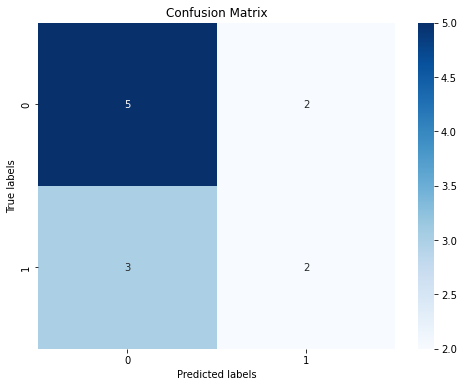

Epoch 1/10
10/10 [==============================] - 1s 7ms/step - loss: 0.4072 - mae: 0.4072
Epoch 2/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3323 - mae: 0.3323
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2929 - mae: 0.2929
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2634 - mae: 0.2634
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2539 - mae: 0.2539
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2395 - mae: 0.2395
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2170 - mae: 0.2170
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.1975 - mae: 0.1975
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2047 - mae: 0.2047
Epoch 10/10
1/1 [==============================] - 0s 188ms/step - loss: 0.2938 - mae: 0.2938


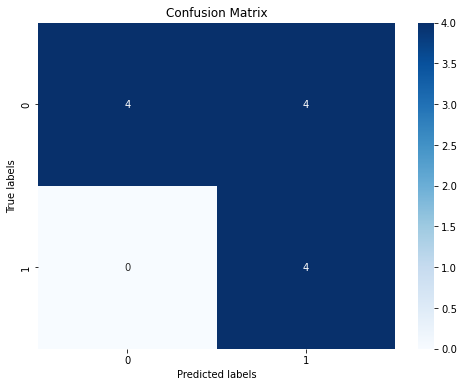

Epoch 1/10
10/10 [==============================] - 1s 1ms/step - loss: 0.3915 - mae: 0.3915
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.3154 - mae: 0.3154
Epoch 3/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2810 - mae: 0.2810
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2451 - mae: 0.2451
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2260 - mae: 0.2260
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.2158 - mae: 0.2158
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2059 - mae: 0.2059
Epoch 8/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1750 - mae: 0.1750
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1503 - mae: 0.1503
Epoch 10/10
1/1 [==============================] - 0s 115ms/step - loss: 0.3658 - mae: 0.3658


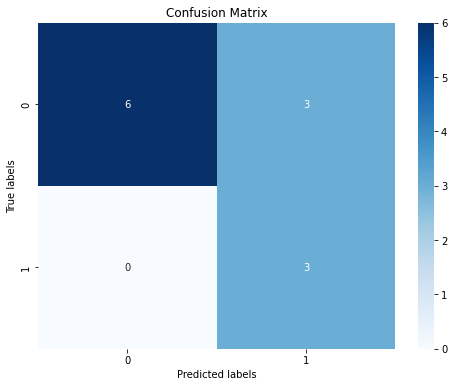

Epoch 1/10
10/10 [==============================] - 1s 2ms/step - loss: 0.4085 - mae: 0.4085
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3663 - mae: 0.3663
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3351 - mae: 0.3351
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3285 - mae: 0.3285
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3122 - mae: 0.3122
Epoch 6/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3312 - mae: 0.3312
Epoch 7/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3119 - mae: 0.3119
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2920 - mae: 0.2920
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3054 - mae: 0.3054
Epoch 10/10
1/1 [==============================] - 0s 198ms/step - loss: 0.3838 - mae: 0.3838


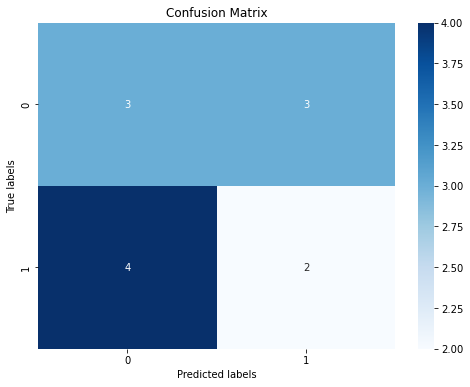

Epoch 1/10
10/10 [==============================] - 1s 2ms/step - loss: 0.4513 - mae: 0.4513
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3941 - mae: 0.3941
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3381 - mae: 0.3381
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3425 - mae: 0.3425
Epoch 5/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3083 - mae: 0.3083
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3029 - mae: 0.3029
Epoch 7/10
10/10 [==============================] - 0s 11ms/step - loss: 0.2992 - mae: 0.2992
Epoch 8/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2704 - mae: 0.2704
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2504 - mae: 0.2504
Epoch 10/10
1/1 [==============================] - 0s 191ms/step - loss: 0.6550 - mae: 0.6550


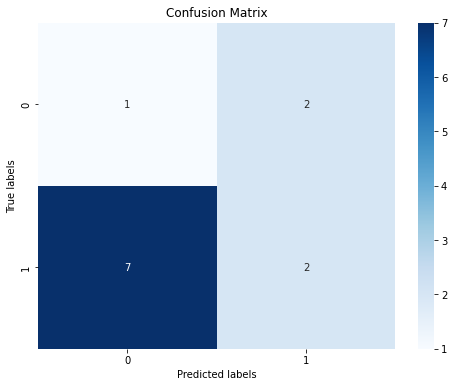

Epoch 1/10
10/10 [==============================] - 1s 8ms/step - loss: 0.4172 - mae: 0.4172
Epoch 2/10
10/10 [==============================] - 0s 11ms/step - loss: 0.4143 - mae: 0.4143
Epoch 3/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3883 - mae: 0.3883
Epoch 4/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3929 - mae: 0.3929
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3998 - mae: 0.3998
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4135 - mae: 0.4135
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - mae: 0.3905
Epoch 8/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3793 - mae: 0.3793
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.3941 - mae: 0.3941
Epoch 10/10
1/1 [==============================] - 0s 143ms/step - loss: 0.2948 - mae: 0.2948


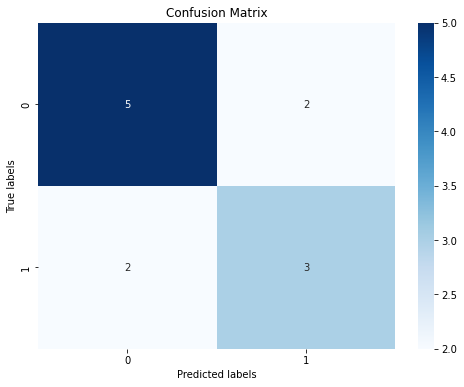

  Window    MAE R_squared Accuracy F1 Score
0      0  0.345    -0.151    0.583    0.574
1      1  0.294    -0.995    0.667    0.667
2      2  0.366    -0.194     0.75    0.767
3      3  0.384    -0.979    0.417    0.413
4      4  0.655    -3.217     0.25    0.276
5      5  0.295     0.035    0.667    0.667


In [8]:
# Import tuned hyper-paramters
hp_results = pd.read_csv("Final results/MLP HPS.csv")

# Years that will be removed from the data set (depending on the window)
bottom_years = ["1990", "1991", "1992", "1993","1994"]
test_years = ["2016", "2017", "2018", "2019", "2020", "2021"]

# Define table to store results
result_mlp = pd.DataFrame(
{"Window":              [None, None, None, None, None, None],
 "MAE":                 [None, None, None, None, None, None],
 "R_squared":           [None, None, None, None, None, None],
 "Accuracy":            [None, None, None, None, None, None],
 "F1 Score":            [None, None, None, None, None, None]
})

# Define np array to store actual and predicted weights
weights_results = pd.DataFrame([[None] * 5] * 72, columns=['Date', 'Actual Stock Weight', 'Actual Bond Weight', 'Predicted Stock Weight', 'Predicted Bond Weight'])

# Loop over each 
for window in range(6):
    # Retrieve hyper-parameters for window
    Window = hp_results.loc[window, ['Window']][0]
    N_hidden_layers = hp_results.loc[window, ['N_hidden_layers']][0]
    N_neurons_layer_1 = hp_results.loc[window, ['N_neurons_layer_1']][0]
    N_neurons_layer_2 = hp_results.loc[window, ['N_neurons_layer_2']][0]
    N_neurons_layer_3 = hp_results.loc[window, ['N_neurons_layer_3']][0]
    Batch_normalization = hp_results.loc[window, ['Batch_normalization']][0]
    Dropout_rate = hp_results.loc[window, ['Dropout_rate']][0]
    Learning_rate = hp_results.loc[window, ['Learning_rate']][0]

    # Exluce the bottom years in training set (depending on window)
    exclude_bottom_years = bottom_years[0:window]
    
    # Exclude test years in training set (depending on window)
    exclude_test_years = test_years[window:]
    
    # Merge years to exclude for training set (depending on window)
    train_exclude= exclude_bottom_years + exclude_test_years

    # Retrieve test year (depending on window)
    test_year = test_years[window]
   
    # Get filtered data set 
    whole_train = df[~df['DATE'].str.contains('|'.join(train_exclude))]
    whole_test = df[df['DATE'].str.contains(test_year)]

    # Select right columns
    X_train = whole_train.iloc[:, 4:]
    y_train = whole_train.iloc[:, [1, 2]]
    X_test = whole_test.iloc[:, 4:]
    y_test = whole_test.iloc[:, [1, 2]]

    # Extract results for each window
    result_window = test_set(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_layers=N_hidden_layers, n_neurons_L1=N_neurons_layer_1,n_neurons_L2=N_neurons_layer_2, n_neurons_L3=N_neurons_layer_3, batch_normalization=Batch_normalization, dropout_rate=Dropout_rate, learning_rate=Learning_rate)
    
    # Assign results to table
    result_mlp.at[window, "Window"] = window
    result_mlp.at[window, "MAE"] = np.round(result_window[0], 3)
    result_mlp.at[window, "R_squared"] = np.round(result_window[1], 3)

    # Assign results to table
    
    dates = list(whole_test.loc[:, "DATE"])
    weights_results.loc[window*12:(window*12+11), "Date"] = dates
    stock_optimal = list(whole_test.loc[:, "Stock index"])
    weights_results.loc[window*12:(window*12+11), "Actual Stock Weight"] = stock_optimal
    bond_optimal = list(whole_test.loc[:, "Bond Index"])
    weights_results.loc[window*12:(window*12+11), "Actual Bond Weight"] = bond_optimal
    pred_stock = list(result_window[3][:, 0])
    weights_results.loc[window*12:(window*12+11), "Predicted Stock Weight"] = pred_stock
    pred_bond = list(result_window[3][:, 1])
    weights_results.loc[window*12:(window*12+11), "Predicted Bond Weight"] = pred_bond
    
    # Rounc for classification results
    round_actual = np.round(result_window[2]).values #convert to np array
    round_pred = np.round(result_window[3])
    row_matches = np.all(round_pred == round_actual, axis=1)

    # Get accuracy and F1 score
    y_pred = (round_pred > 0.5)
    acc = accuracy_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    result_mlp.at[window, "Accuracy"] = round(acc, 3)
    f1 = f1_score(round_actual.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
    result_mlp.at[window, "F1 Score"] = round(f1, 3)
    	
    # Plot confusion matrix
    cm = confusion_matrix(round_actual.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
   
result_mlp.to_csv("Final results/MLP Final Results.csv")
weights_results.to_csv("Final results/MLP Weight predictions.csv")
print(result_mlp)